In [14]:
%load_ext autoreload
%autoreload 2
INPUT_NAME = "embeddings.parquet"
OUTPUT_NAME = "20250510-v5-dino-k1"
DESCRIPTION = f"{INPUT_NAME}, k=1 on neighbors, modified z-score"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from animalclef.spark import get_spark
from pyspark.sql import functions as F, Window
from pathlib import Path
import numpy as np
from animalclef.dataset import split_reid_data, summarize_split
import pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from tqdm import tqdm
import faiss
from animalclef.metrics import BAKS, BAUS
from collections import Counter


def get_min_distance_to_neighbor(train_df, k=1):
    @lru_cache(maxsize=16)
    def get_index(individual):
        """get all embeddings that do not belong to an individual. This will form
        the minimum intercluster distance."""
        sub = train_df[train_df.identity != individual]
        # Use the dimension of the embedding vectors
        embedding_dim = len(sub.embeddings.iloc[0])
        index = faiss.IndexFlatL2(embedding_dim)
        index.add(np.stack(sub.embeddings.values))
        return index

    distances = []
    # order the training set by identity so that our lru cache is more efficient
    train_df = train_df.sort_values(by="identity")
    for row in tqdm(train_df.itertuples(), total=len(train_df)):
        # get the index for the individual
        index = get_index(row.identity)
        # search for the nearest neighbor in the training set
        dist, _ = index.search(np.array([row.embeddings]), k)
        # get the average distance to the nearest neighbors
        distances.append(np.median(dist))
    return np.array(distances)


def summarize_distances(distances):
    print(f"Min distance: {distances.min()}")
    print(f"Max distance: {distances.max()}")
    print(f"Mean distance: {distances.mean()}")
    print(f"Std distance: {distances.std()}")
    # IQR
    q1 = np.percentile(distances, 25)
    q2 = np.percentile(distances, 50)
    q3 = np.percentile(distances, 75)
    iqr = q3 - q1
    print(f"IQR: {iqr}")
    print(f"Q1: {q1}")
    print(f"Q3: {q3}")
    print(f"Median: {q2}")
    mad = np.median(np.abs(distances - np.median(distances)))
    print(f"MAD: {mad}")


def make_prediction(
    train_df: pd.DataFrame,
    other_df: pd.DataFrame,
    median: float,
    mad: float,
    threshold: float,
    k: int = 1,
    new_label: str = "new_individual",
) -> np.ndarray:

    X_train = np.stack(train_df.embeddings.values)
    X_other = np.stack(other_df.embeddings.values)

    index = faiss.IndexFlatL2(X_train.shape[1])
    index.add(X_train)

    dist, idx = index.search(X_other, k)

    predictions = []
    for i, (dists, ids) in enumerate(zip(dist, idx)):
        # filter ids where the distance is above the thresold
        filtered_ids = []
        for dist, id_ in zip(dists, ids):
            score = (dist - median) / (mad * 1.4826)
            if score < threshold:
                filtered_ids.append(id_)

        if len(filtered_ids) == 0:
            predictions.append(new_label)
        else:
            # get the most common identity among the k nearest neighbors
            counts = Counter(train_df.iloc[filtered_ids]["identity"].values)
            predictions.append(counts.most_common(1)[0][0])
    return np.array(predictions)


def search_threshold(train_df, other_df, median, mad, thresholds, k=1):
    identity_other_only = sorted(
        set(other_df.identity.unique()) - set(train_df.identity.unique())
    )

    scores = []
    for threshold in tqdm(thresholds):
        predictions = make_prediction(train_df, other_df, median, mad, threshold, k=k)
        baks = BAKS(other_df["identity"].values, predictions, identity_other_only)
        baus = BAUS(
            other_df["identity"].values,
            predictions,
            identity_other_only,
            "new_individual",
        )
        # geometric average
        scores.append(
            {
                "threshold": threshold,
                "baks": baks,
                "baus": baus,
                "crossover_score": 1 - abs(baks - baus),
                "score": np.sqrt(baks * baus),
            }
        )
    return pd.DataFrame(scores)


def plot_threshold_score(df, col="threshold"):
    best_score_row = df.iloc[df["score"].idxmax()]
    best_score_threshold = best_score_row[col]
    display(best_score_row.to_dict())

    best_crossover_score_row = df.iloc[df["crossover_score"].idxmax()]
    best_crossover_score_threshold = best_crossover_score_row[col]
    # display(best_crossover_score_row.to_dict())

    # plot baus and baks
    plt.plot(
        df[col],
        df["baks"],
        label=f"BAKS (best {df['baks'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["baus"],
        label=f"BAUS (best {df['baus'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["score"],
        label=f"score (best {df["score"].max():.2f})",
    )
    # line at the best threshold
    plt.axvline(
        best_score_threshold,
        color="red",
        linestyle="--",
        label=f"best threshold: {best_score_threshold:.2f}",
    )
    plt.axvline(
        best_crossover_score_threshold,
        color="blue",
        linestyle="--",
        label=f"crossover threshold: {best_crossover_score_threshold:.2f}",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Geometric mean of BAKS and BAUS")
    plt.title("Threshold vs Geometric mean of BAKS and BAUS")
    plt.legend()
    plt.show()


def experiment_threshold(train_df, val_df, num_neighbors=1):
    # get stats on the distances
    distances = get_min_distance_to_neighbor(train_df, k=num_neighbors)
    summarize_distances(distances)

    median = np.median(distances)
    mad = np.median(np.abs(distances - median))
    thresholds = np.linspace(-2, 8, 100)
    mad_threshold_df = search_threshold(
        train_df,
        val_df,
        median=median,
        mad=mad,
        thresholds=thresholds,
        k=num_neighbors,
    )
    # add k as a column
    mad_threshold_df["median"] = median
    mad_threshold_df["mad"] = mad
    mad_threshold_df["num_neighbors"] = num_neighbors
    mad_threshold_df["k"] = thresholds
    # display(mad_threshold_df)
    plot_threshold_score(mad_threshold_df, col="k")
    return mad_threshold_df

In [4]:
spark = get_spark(cores=4, memory="2g")

root = Path.home() / "scratch/animalclef"
metadata = spark.read.csv(f"{root}/raw/metadata.csv", header=True, inferSchema=True)
embeddings = spark.read.parquet(f"{root}/processed/{INPUT_NAME}")
embeddings = embeddings.select("image_id", "embeddings")
df = metadata.join(embeddings, on="image_id", how="inner").select(
    "image_id",
    "identity",
    "dataset",
    "embeddings",
    F.count("image_id").over(Window.partitionBy("identity")).alias("identity_count"),
)
df.printSchema()
pdf = df.toPandas()

# do the test split
cond = (~pdf.identity.isnull()) & (pdf.identity_count > 2)
train_df, val_df, test_df = split_reid_data(pdf[cond])
display(summarize_split(train_df, val_df, test_df))

25/05/11 05:53:45 WARN Utils: Your hostname, hawksbill-vm resolves to a loopback address: 127.0.1.1; using 192.168.10.12 instead (on interface ens18)
25/05/11 05:53:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/11 05:53:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/11 05:53:45 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/05/11 05:53:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- embeddings: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- identity_count: long (nullable = false)



,Split,Num Individuals,Num Images,Train Image Overlap,Val Image Overlap,Test Image Overlap,Train Image %,Val Image %,Test Image %,Known Individuals,Unknown Individuals
0,Train,404,3392,3392,0,0,100.0,0.0,0.0,404,0
1,Validation,458,2575,0,2575,0,0.0,100.0,0.0,404,54
2,Test,620,6568,0,0,6568,0.0,0.0,100.0,404,216


Experimenting with k=1


  0%|          | 0/3392 [00:00<?, ?it/s]

100%|██████████| 3392/3392 [00:31<00:00, 106.89it/s]


Min distance: 183.87872314453125
Max distance: 2869.53271484375
Mean distance: 660.7181396484375
Std distance: 328.1961975097656
IQR: 412.35711669921875
Q1: 418.39263916015625
Q3: 830.749755859375
Median: 570.0442504882812
MAD: 181.30148315429688


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


{'threshold': -0.48484848484848486,
 'baks': 0.18434359642276765,
 'baus': 0.6487759377094836,
 'crossover_score': 0.535567658713284,
 'score': 0.34582898899589043,
 'k': -0.48484848484848486}

{'threshold': 0.5252525252525251,
 'baks': 0.26557780439725354,
 'baus': 0.28239484173823826,
 'crossover_score': 0.9831829626590153,
 'score': 0.2738572658191694,
 'k': 0.5252525252525251}

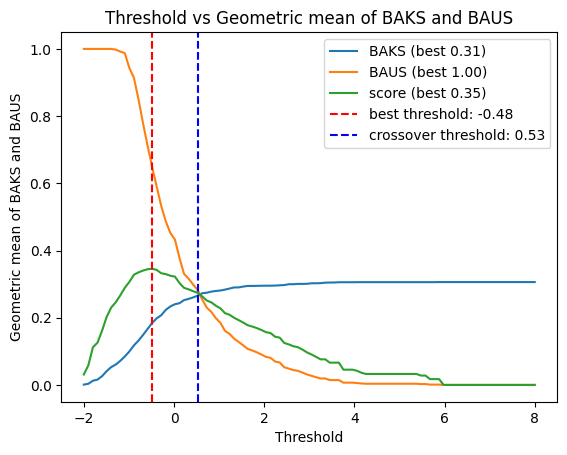

Experimenting with k=3


100%|██████████| 3392/3392 [00:31<00:00, 106.89it/s]


Min distance: 195.41958618164062
Max distance: 2941.892578125
Mean distance: 709.3347778320312
Std distance: 348.5106506347656
IQR: 440.2483215332031
Q1: 447.5191955566406
Q3: 887.7675170898438
Median: 613.4327392578125
MAD: 196.4646453857422


100%|██████████| 100/100 [01:19<00:00,  1.27it/s]


{'threshold': -0.5858585858585859,
 'baks': 0.17895449626588478,
 'baus': 0.6437776731565206,
 'crossover_score': 0.5351768231093642,
 'score': 0.3394214330400315,
 'k': -0.5858585858585859}

{'threshold': 0.4242424242424243,
 'baks': 0.26209755467985973,
 'baus': 0.25425258436202686,
 'crossover_score': 0.9921550296821671,
 'score': 0.2581452704047122,
 'k': 0.4242424242424243}

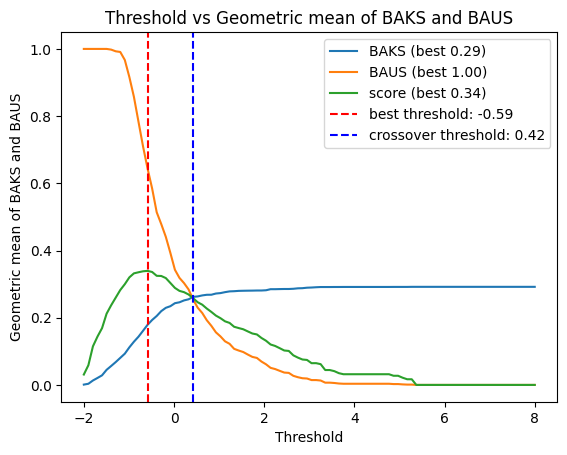

Experimenting with k=5


100%|██████████| 3392/3392 [00:31<00:00, 107.04it/s]


Min distance: 206.72647094726562
Max distance: 3010.05908203125
Mean distance: 737.9010009765625
Std distance: 361.20928955078125
IQR: 453.358642578125
Q1: 468.08709716796875
Q3: 921.4457397460938
Median: 636.97900390625
MAD: 203.6084747314453


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


{'threshold': -0.5858585858585859,
 'baks': 0.1852132715366926,
 'baus': 0.6049100189753254,
 'crossover_score': 0.5803032525613672,
 'score': 0.33471982851295623,
 'k': -0.5858585858585859}

{'threshold': 0.3232323232323231,
 'baks': 0.2436906099301685,
 'baus': 0.2551785102879528,
 'crossover_score': 0.9885120996422156,
 'score': 0.24936841582915625,
 'k': 0.3232323232323231}

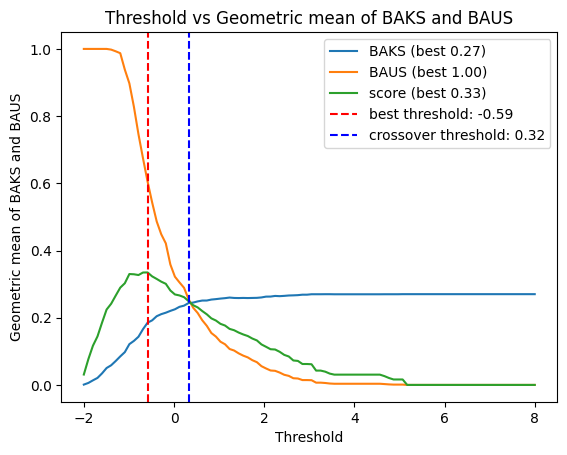

Experimenting with k=10


100%|██████████| 3392/3392 [00:31<00:00, 106.90it/s]


Min distance: 278.60980224609375
Max distance: 3058.202392578125
Mean distance: 782.22216796875
Std distance: 380.9974365234375
IQR: 487.5185546875
Q1: 493.641357421875
Q3: 981.159912109375
Median: 669.841552734375
MAD: 212.7052459716797


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


{'threshold': -0.8888888888888888,
 'baks': 0.13475483870543847,
 'baus': 0.7672859471567779,
 'crossover_score': 0.3674688915486606,
 'score': 0.3215516973210703,
 'k': -0.8888888888888888}

{'threshold': 0.5252525252525251,
 'baks': 0.19576181284898467,
 'baus': 0.19082200398050306,
 'crossover_score': 0.9950601911315184,
 'score': 0.1932761274205882,
 'k': 0.5252525252525251}

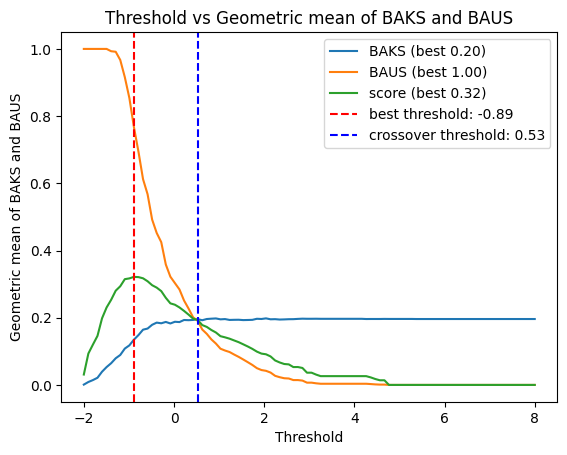

Experimenting with k=20


100%|██████████| 3392/3392 [00:31<00:00, 106.93it/s]


Min distance: 310.45654296875
Max distance: 3160.0087890625
Mean distance: 835.3594360351562
Std distance: 406.6708679199219
IQR: 515.892822265625
Q1: 527.127685546875
Q3: 1043.0205078125
Median: 712.069091796875
MAD: 219.88882446289062


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


{'threshold': -0.8888888888888888,
 'baks': 0.14985245014251541,
 'baus': 0.6912340156792502,
 'crossover_score': 0.4586184344632651,
 'score': 0.32184330173453285,
 'k': -0.8888888888888888}

{'threshold': 0.4242424242424243,
 'baks': 0.16870544006149343,
 'baus': 0.17998137348148743,
 'crossover_score': 0.988724066580006,
 'score': 0.1742522218396837,
 'k': 0.4242424242424243}

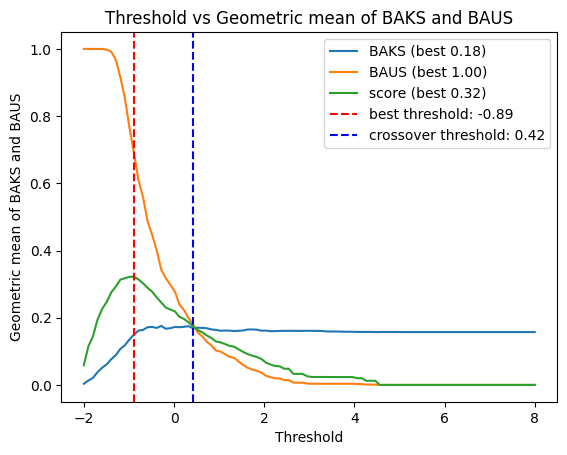

In [8]:
for k in [1, 3, 5, 10, 20]:
    print(f"Experimenting with k={k}")
    mad_threshold_df = experiment_threshold(train_df, val_df, num_neighbors=k)

Looks like the score increases if we include more items in the training dataset. This intuitively makes sense because we have more distances to look at.

# final prediction

  0%|          | 1/5967 [00:00<13:11,  7.53it/s]

100%|██████████| 5967/5967 [01:07<00:00, 89.00it/s] 


Min distance: 183.87872314453125
Max distance: 2869.53271484375
Mean distance: 631.4503784179688
Std distance: 315.107177734375
IQR: 380.7972106933594
Q1: 400.9151916503906
Q3: 781.71240234375
Median: 539.4848022460938
MAD: 170.0828857421875


100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


{'threshold': -0.5858585858585859,
 'baks': 0.21235654882611218,
 'baus': 0.7276769572576244,
 'crossover_score': 0.48467959156848783,
 'score': 0.39309918252715237,
 'median': 539.4848022460938,
 'mad': 170.0828857421875,
 'num_neighbors': 1.0,
 'k': -0.5858585858585859}

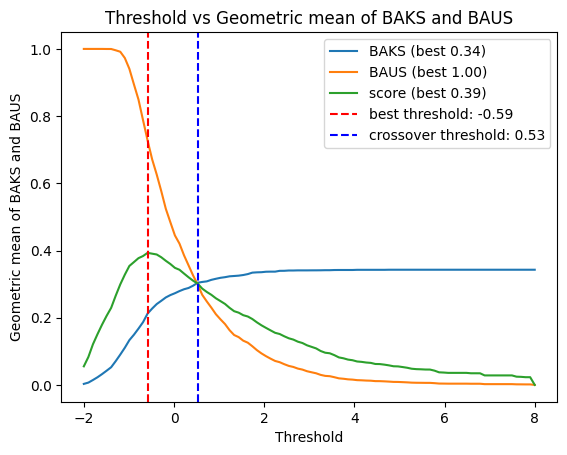

{'threshold': -0.5858585858585859,
 'baks': 0.21235654882611218,
 'baus': 0.7276769572576244,
 'crossover_score': 0.48467959156848783,
 'score': 0.39309918252715237,
 'median': 539.4848022460938,
 'mad': 170.0828857421875,
 'num_neighbors': 1.0,
 'k': -0.5858585858585859}

In [11]:
# now for the final prediction
known_df = pdf[pdf.identity.notnull()]
unknown_df = pdf[pdf.identity.isnull()]
num_neighbors = 1

mad_threshold_df = experiment_threshold(
    pd.concat([train_df, val_df]), test_df, num_neighbors=num_neighbors
)
row = mad_threshold_df.iloc[mad_threshold_df["score"].idxmax()]
display(row.to_dict())

In [15]:
predictions = make_prediction(
    known_df, unknown_df, row["median"], row["mad"], row["k"], k=num_neighbors
)
# count how many are predicted as "unknown"
display(
    {
        "unknown": len(predictions[predictions == "new_individual"]),
        "known": len(predictions[predictions != "new_individual"]),
        "total": len(predictions),
    }
)
# save this result
unknown_df["identity"] = predictions
output_path = Path.home() / f"shared/animalclef/data/predictions/{OUTPUT_NAME}.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)
unknown_df[["image_id", "identity"]].to_csv(output_path, index=False, header=True)

{'unknown': 1432, 'known': 703, 'total': 2135}

/tmp/ipykernel_456113/1455382000.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df["identity"] = predictions


In [16]:
! kaggle competitions submit -c animal-clef-2025 -f {output_path} -m "{DESCRIPTION}"

100%|██████████████████████████████████████| 45.7k/45.7k [00:00<00:00, 71.7kB/s]
Successfully submitted to AnimalCLEF25 @ CVPR-FGVC & LifeCLEF